In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
from edward.models.random_variable import RandomVariable
from edward.models.random_variables import Bernoulli, Beta
from tensorflow.contrib.distributions import Distribution
from edward.models import Bernoulli, Beta, Exponential, Normal
plt.style.use('ggplot')

In [4]:
x = tf.zeros((1,3))
y = tf.zeros((4,5))
print(x.shape.concatenate(y.shape))
a = tf.zeros([0] + x.shape.as_list() + y.shape.as_list())
print(a.shape)
print(tf.shape(a))
print(a.get_shape())

(1, 3, 4, 5)
(0, 1, 3, 4, 5)
Tensor("Shape:0", shape=(5,), dtype=int32)
(0, 1, 3, 4, 5)


In [5]:
class DirichletProcess(RandomVariable, Distribution):
  def __init__(self, alpha, base_cls, validate_args=False, allow_nan_stats=True,
               name="DirichletProcess", value=None, *args, **kwargs):
    """Dirichlet process :math:`\mathcal{DP}(\\alpha, H)`.

    It has two parameters: a positive real value :math:`\\alpha`,
    known as the concentration parameter (``alpha``), and a base
    distribution :math:`H` (``base_cls(*args, **kwargs)``).

    Parameters
    ----------
    alpha : tf.Tensor
      Concentration parameter. Must be positive real-valued. Its shape
      determines the number of independent DPs (batch shape).
    base_cls : RandomVariable
      Class of base distribution. Its shape (when instantiated)
      determines the shape of an individual DP (event shape).
    *args, **kwargs : optional
      Arguments passed into ``base_cls``.

    Examples
    --------
    >>> # scalar concentration parameter, scalar base distribution
    >>> dp = DirichletProcess(0.1, Normal, mu=0.0, sigma=1.0)
    >>> assert dp.get_shape() == ()
    >>>
    >>> # vector of concentration parameters, matrix of Exponentials
    >>> dp = DirichletProcess(tf.constant([0.1, 0.4]),
    ...                       Exponential, lam=tf.ones([5, 3]))
    >>> assert dp.get_shape() == (2, 5, 3)
    """
    parameters = locals()
    parameters.pop("self")
    with tf.name_scope(name, values=[alpha]) as ns:
      with tf.control_dependencies([]):
        self._alpha = tf.identity(alpha, name="alpha")
        self._base_cls = base_cls
        self._base_args = args
        self._base_kwargs = kwargs

        # Instantiate base distribution.
        self._base = self._base_cls(*self._base_args, **self._base_kwargs)
        # Create empty tensor to store future atoms in
        self._theta = tf.zeros(
            [0] + self.get_batch_shape().as_list() +
            self.get_event_shape().as_list())
        # self._theta = tf.expand_dims(
            # self._base.sample(self.get_batch_shape()), 0)

        # Instantiate beta distribution for stick breaking proportions
        self._betadist = Beta(a=tf.ones_like(self.alpha), b=self.alpha)
        # Create empty tensor to store stick breaking proportions
        self._beta = tf.zeros([0] + self.get_batch_shape().as_list())

        super(DirichletProcess, self).__init__(
            dtype=tf.float32,
            is_continuous=False,
            is_reparameterized=False,
            validate_args=validate_args,
            allow_nan_stats=allow_nan_stats,
            parameters=parameters,
            graph_parents=[self._alpha, self._theta, self._beta],
            name=ns,
            value=value)

  @property
  def alpha(self):
    """Concentration parameter."""
    return self._alpha

  @property
  def beta(self):
    """Stick breaking proportions. It has shape [None] + batch_shape, where
    the first dimension is the number of atoms, instantiated only as
    needed."""
    return self._beta

  @property
  def theta(self):
    """Atoms. It has shape [None] + batch_shape + event_shape, where
    the first dimension is the number of atoms, instantiated only as
    needed."""
    return self._theta

  def _batch_shape(self):
    return tf.shape(self.alpha)

  def _get_batch_shape(self):
    return self.alpha.get_shape()

  def _event_shape(self):
    return tf.shape(self._base)

  def _get_event_shape(self):
    return self._base.get_shape()

  def _sample_n(self, n, seed=None):
    """Sample ``n`` draws from the DP. Draws from the base
    distribution are memoized across ``n`` and across calls to
    ``sample()``.

    Draws from the base distribution are not memoized across the batch
    shape, i.e., each independent DP in the batch shape has its own
    memoized samples.

    Returns
    -------
    tf.Tensor
      A ``tf.Tensor`` of shape ``[n] + batch_shape + event_shape``,
      where ``n`` is the number of samples for each DP,
      ``batch_shape`` is the number of independent DPs, and
      ``event_shape`` is the shape of the base distribution.

    Notes
    -----
    The implementation has one inefficiency, which is that it draws
    (batch_shape,) samples from the base distribution when adding a
    new persistent state. Ideally, we would only draw new samples for
    those in the loop which require it.
    """
    if seed is not None:
      raise NotImplementedError("seed is not implemented.")

    batch_shape = self.get_batch_shape().as_list()
    event_shape = self.get_event_shape().as_list()
    rank = 1 + len(batch_shape) + len(event_shape)
    # Note this is for scoping within the while loop's body function.
    self._temp_scope = [n, batch_shape, event_shape, rank]

    # Start at the beginning of the stick, i.e. the k'th index
    k = tf.constant(0)

    # Define boolean tensor. It is True for samples that require continuing
    # the while loop and False for samples that can receive their base
    # distribution (coin lands heads).
    bools = tf.ones([n] + self.get_batch_shape().as_list(), dtype=tf.bool)

    # Initialize all samples as zero, they will be overwritten in any case
    draws = tf.zeros([n] + batch_shape + event_shape)

    # Calculate shape invariance conditions for theta and beta as these
    # can change shape between loop iterations.
    theta_shape = tf.TensorShape([None])
    beta_shape = tf.TensorShape([None])
    if len(self.theta.shape) > 1:
      theta_shape = theta_shape.concatenate(self.theta.shape[1:])
      beta_shape = beta_shape.concatenate(self.beta.shape[1:])

    # While we have not broken enough sticks, keep sampling.
    _, _, self._theta, self._beta, samples = tf.while_loop(
        self._sample_n_cond, self._sample_n_body,
        loop_vars=[k, bools, self.theta, self.beta, draws],
        shape_invariants=[k.shape, bools.shape, theta_shape, beta_shape, draws.shape])

    return samples

  def _sample_n_cond(self, k, bools, theta, beta, draws):
    # Proceed if at least one bool is True.
    return tf.reduce_any(bools)

  def _sample_n_body(self, k, bools, theta, beta, draws):
    n, batch_shape, event_shape, rank = self._temp_scope

    # If necessary, break a new piece of stick, i.e.
    # add a new persistent atom to theta and sample another beta
    theta, beta = tf.cond(
        tf.shape(theta)[0] - 1 >= k,
        lambda: (theta, beta),
        lambda: (
            tf.concat(
                [theta, tf.expand_dims(self._base.sample(batch_shape), 0)], 0),
            tf.concat(
                [beta, tf.expand_dims(self._betadist.sample(), 0)], 0)))
    theta_k = tf.gather(theta, k)
    beta_k = tf.gather(beta, k)

    # Assign True samples to the new theta_k.
    if len(bools.get_shape()) <= 1:
      bools_tile = bools
    else:
      # ``tf.where`` only index subsets when ``bools`` is at most a
      # vector. In general, ``bools`` has shape (n, batch_shape).
      # Therefore we tile ``bools`` to be of shape
      # (n, batch_shape, event_shape) in order to index per-element.
      bools_tile = tf.tile(tf.reshape(
          bools, [n] + batch_shape + [1] * len(event_shape)),
          [1] + [1] * len(batch_shape) + event_shape)

    theta_k_tile = tf.tile(tf.expand_dims(theta_k, 0), [n] + [1] * (rank - 1))
    draws = tf.where(bools_tile, theta_k_tile, draws)

    # Draw new stick probability, then flip coins.
    flips = Bernoulli(p=beta_k).sample(n)
    # If coin lands heads, assign sample's corresponding bool to False
    # (this ends its "while loop").
    bools = tf.where(tf.cast(flips, tf.bool), tf.zeros_like(bools), bools)
    return k+1, bools, theta, beta, draws

In [6]:
sess = tf.Session()

# Demo of the DirichletProcess random variable in Edward.
base_cls = Normal
kwargs = {'mu': 0.0, 'sigma': 1.0}

# Highly concentrated DP.
alpha = 1.0
dp = DirichletProcess(alpha, base_cls, **kwargs)

In [7]:
x = dp.sample(100)

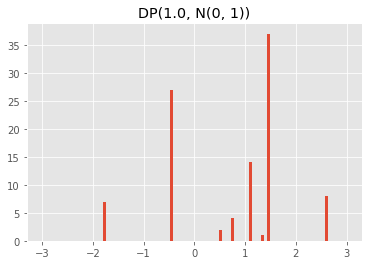

In [8]:
samples = sess.run(x)
plt.hist(samples, bins=100, range=(-3.0, 3.0))
plt.title("DP({0}, N(0, 1))".format(alpha))
plt.show()

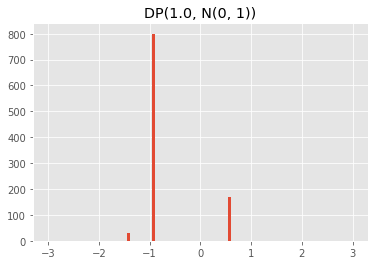

In [9]:
# Highly concentrated DP.
alpha = 1.0
dp = DirichletProcess(alpha, base_cls, **kwargs)
x = dp.sample(1000)
samples = sess.run(x)
plt.hist(samples, bins=100, range=(-3.0, 3.0))
plt.title("DP({0}, N(0, 1))".format(alpha))
plt.show()

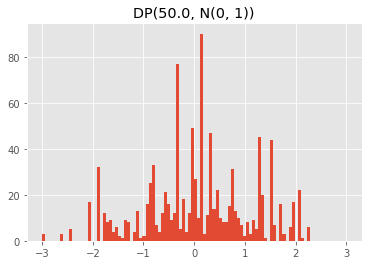

In [10]:
# More spread out DP.
alpha = 50.0
dp = DirichletProcess(alpha, base_cls, **kwargs)
x = dp.sample(1000)
samples = sess.run(x)
plt.hist(samples, bins=100, range=(-3.0, 3.0))
plt.title("DP({0}, N(0, 1))".format(alpha))
plt.show()

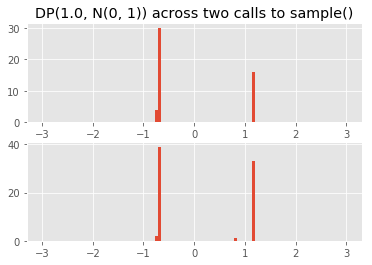

In [11]:
# States persist across calls to sample() in a DP.
alpha = 1.0
dp = DirichletProcess(alpha, base_cls, **kwargs)
x = dp.sample(50)
y = dp.sample(75)
samples_x, samples_y = sess.run([x, y])
plt.subplot(211)
plt.hist(samples_x, bins=100, range=(-3.0, 3.0))
plt.title("DP({0}, N(0, 1)) across two calls to sample()".format(alpha))
plt.subplot(212)
plt.hist(samples_y, bins=100, range=(-3.0, 3.0))
plt.show()

In [12]:
# ``theta`` is the distribution indirectly returned by the DP.
# Fetching theta is the same as fetching the Dirichlet process.
dp = DirichletProcess(alpha, base_cls, **kwargs)
theta = base_cls(value=tf.cast(dp, tf.float32), **kwargs)
print(sess.run([dp, theta]))
print(sess.run([dp, theta]))

[0.23665094, 0.23665094]
[-0.49100482, -0.49100482]


In [13]:
# DirichletProcess can also take in non-scalar concentrations and bases.
base_cls = Exponential
kwargs = {'lam': tf.ones([5, 2])}
dp = DirichletProcess(tf.constant([0.1, 0.6, 0.4]), base_cls, **kwargs)
print(dp)

RandomVariable("DirichletProcess_5/", shape=(3, 5, 2), dtype=float32)
